<h1>Logistic Regression for prediction of leading role gender in movies</h1> 

<h2>Import necessary libraries</h2>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as slm
import sklearn.model_selection as sms
import sklearn.metrics as sm
import sklearn.preprocessing as spp
import sklearn.pipeline as spl
import sklearn
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.base import BaseEstimator, ClassifierMixin
import sklearn.base as base
import sklearn.metrics as metrics

<h2>Some useful functions</h2> 

In [ ]:
# For removal of outliers, as a part of the sklearn pipeline process
class WithoutOutliersClassifier(base.BaseEstimator, base.ClassifierMixin):
    def __init__(self, outlier_detector, classifier, remove_outliers=True):
        self.outlier_detector = outlier_detector
        self.classifier = classifier
        self.remove_outliers = remove_outliers   # Provides an easy way to run without outlier removal

    def fit(self, X, y):
        self.outlier_detector_ = base.clone(self.outlier_detector)
        if self.remove_outliers:
            mask = self.outlier_detector_.fit_predict(X, y) == 1
            self.classifier_ = base.clone(self.classifier).fit(X[mask], y[mask])
        else:
            self.classifier_ = base.clone(self.classifier).fit(X, y)
        return self
    
    def predict(self, X):
        return self.classifier_.predict(X)
    
    def decision_function(self, X):
        return self.classifier_.decision_function(X)
        #return self.predict_proba(X)[:,1]
    
    def predict_proba(self, X):
        return self.classifier_.predict_proba(X)        

In [ ]:
# Feature engineering
def preprocess(dataset, add_features=None, keep_features="all"):
    
    train_data = dataset.copy()

    if keep_features != "all":
        features = keep_features
        features.append(LABEL_COLUMN)
        train_data = train_data[features]

    if add_features == "ratio_female":
        train_data.insert(len(train_data.columns)-1, column="Ratio female actors", value=dataset["Number of female actors"] / (dataset["Number of male actors"] + dataset["Number of female actors"]))
    
    if add_features == "add_ratios": 
        train_data.insert(len(train_data.columns)-1, column="Ratio female actors", value=dataset["Number of female actors"] / (dataset["Number of male actors"] + dataset["Number of female actors"]))
        train_data.insert(len(train_data.columns)-1, column="Ratio female words", value=dataset["Number words female"] / dataset["Total words"])
        train_data.insert(len(train_data.columns)-1, column="Ratio lead words", value=dataset["Difference in words lead and co-lead"] / dataset["Total words"])
    
    return train_data

In [ ]:
# sklearn pipeline with outlier removal and scaling
def create_pipeline(lr_model, remove_outliers=True, use_scaling=True):
    scaler = spp.StandardScaler()
    ol = LocalOutlierFactor(n_neighbors=2)
    #ol = IsolationForest(n_estimators=10, warm_start=True)
    #ol = OneClassSVM()
    woc = WithoutOutliersClassifier(ol, lr_model, remove_outliers)
    
    if use_scaling:
        p = [("preprocess", scaler)]
    else:
        p = []
    
    p.append(("lr", woc))
    
    return spl.Pipeline(p)

In [71]:
# Tune parameters for the model, with outlier removal as part of the pipeline
def tune(lr_model, X_train, y_train, R=5, K=10):

    # Set up the CV grid search for tuning
    lambda_exp_min = -0.5
    lambda_exp_max = 1.5
    search_range = {
                     "lr__classifier__C":[1/(10**x) for x in np.linspace(lambda_exp_min, lambda_exp_max, 40)],
                     "lr__classifier__penalty":["l1", "l2"]
                   }
    
    rkf = sms.RepeatedStratifiedKFold(n_repeats=R, n_splits=K, random_state=17)

    pipe = create_pipeline(lr_model, remove_outliers=True, use_scaling=True)
    
    grid_search = sms.GridSearchCV(estimator=pipe,
                                   param_grid=search_range,
                                   cv=rkf,
                                   scoring="accuracy",
                                   return_train_score=True,
                                   verbose=1)

    # Search for the best lambda, using repeated 10-fold cross-valiation to evaluate each lambda value
    grid_search.fit(X_train, y_train)
    
    # Return the result:
    
    # 1. The best model found during the tuning and
    best_lr_model = grid_search.best_estimator_.named_steps["lr"].classifier_

    # 2. The trainset and testset scores, for evaluating the suitable hyperparameter ranges. We do this for both L1 and L2 regularisation.
    scores = grid_search.cv_results_
    
    return (best_lr_model, scores)

In [72]:
# Extract scores from the complicated grid search cv result structure
def get_tuning_scores(res, penalty, lambdas_key, scores_key):
    return (res[lambdas_key][res["param_lr__classifier__penalty"]==penalty].astype("float"),
            res[scores_key] [res["param_lr__classifier__penalty"]==penalty])

<h2>Preprocessing</h2>

In [73]:
# Read training data
LABEL_COLUMN = "Lead"
raw_data = pd.read_csv("train.csv")
raw_data

,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead,Lead
0,1512,6394,2251.0,343,2,1995,5,2631,142.0,51.500000,42.333333,46.0,65.0,Female
1,1524,8780,2020.0,1219,9,2001,4,5236,37.0,39.125000,29.333333,58.0,34.0,Male
2,155,4176,942.0,787,7,1968,1,3079,376.0,42.500000,37.000000,46.0,37.0,Male
3,1073,9855,3440.0,2623,12,2002,2,5342,19.0,35.222222,21.500000,33.0,23.0,Male
4,1317,7688,3835.0,3149,8,1988,4,2536,40.0,45.250000,45.000000,36.0,39.0,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,303,2398,1334.0,1166,5,1973,2,761,174.0,43.200000,31.000000,46.0,24.0,Male
1035,632,8404,1952.0,187,6,1992,2,5820,172.0,37.166667,24.000000,21.0,34.0,Female
1036,1326,2750,877.0,356,2,2000,3,547,53.0,27.500000,27.666667,28.0,25.0,Male
1037,462,3994,775.0,52,8,1996,3,2757,32.0,42.857143,38.500000,29.0,32.0,Female


In [74]:
print("Ratio of movies with female lead:", len(raw_data[raw_data["Lead"]=="Female"])/len(raw_data))

Ratio of movies with female lead: 0.24446583253128007


In [115]:
train_data = preprocess(raw_data, add_features="add_ratios")

X_train = train_data.loc[:, train_data.columns != LABEL_COLUMN].values
y_train = train_data.loc[:, train_data.columns == LABEL_COLUMN].values.ravel()
X = X_train
y = y_train

In [116]:
train_data

,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead,Ratio female actors,Ratio female words,Ratio lead words,Lead
0,1512,6394,2251.0,343,2,1995,5,2631,142.0,51.500000,42.333333,46.0,65.0,0.714286,0.236472,0.053644,Female
1,1524,8780,2020.0,1219,9,2001,4,5236,37.0,39.125000,29.333333,58.0,34.0,0.307692,0.173576,0.138838,Male
2,155,4176,942.0,787,7,1968,1,3079,376.0,42.500000,37.000000,46.0,37.0,0.125000,0.037117,0.188458,Male
3,1073,9855,3440.0,2623,12,2002,2,5342,19.0,35.222222,21.500000,33.0,23.0,0.142857,0.108879,0.266159,Male
4,1317,7688,3835.0,3149,8,1988,4,2536,40.0,45.250000,45.000000,36.0,39.0,0.333333,0.171306,0.409599,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,303,2398,1334.0,1166,5,1973,2,761,174.0,43.200000,31.000000,46.0,24.0,0.285714,0.126355,0.486239,Male
1035,632,8404,1952.0,187,6,1992,2,5820,172.0,37.166667,24.000000,21.0,34.0,0.250000,0.075202,0.022251,Female
1036,1326,2750,877.0,356,2,2000,3,547,53.0,27.500000,27.666667,28.0,25.0,0.600000,0.482182,0.129455,Male
1037,462,3994,775.0,52,8,1996,3,2757,32.0,42.857143,38.500000,29.0,32.0,0.272727,0.115674,0.013020,Female


<h2>Tuning and training</h2>

Fitting 50 folds for each of 80 candidates, totalling 4000 fits


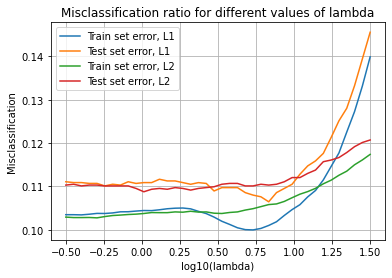

In [117]:
# Search for suitable hyper parameters, compare L1 and L2, and check whether overfit/underfit may occur
lr = slm.LogisticRegression(solver='liblinear')

result = tune(lr, X_train, y_train, R=5, K=10)

best_model = result[0]
scores = result[1]

res_train_L1 = get_tuning_scores(scores, "l1", "param_lr__classifier__C", "mean_train_score")
res_test_L1  = get_tuning_scores(scores, "l1", "param_lr__classifier__C", "mean_test_score")
res_train_L2 = get_tuning_scores(scores, "l2", "param_lr__classifier__C", "mean_train_score")
res_test_L2  = get_tuning_scores(scores, "l2", "param_lr__classifier__C", "mean_test_score")

plt.plot(np.log10(1/res_train_L1[0]), 1-res_train_L1[1], label="Train set error, L1")
plt.plot(np.log10(1/res_test_L1[0]), 1-res_test_L1[1], label="Test set error, L1")
plt.plot(np.log10(1/res_train_L2[0]), 1-res_train_L2[1], label="Train set error, L2")
plt.plot(np.log10(1/res_test_L2[0]), 1-res_test_L2[1], label="Test set error, L2")

plt.legend()
plt.xlabel("log10(lambda)")
plt.ylabel("Misclassification")
plt.title("Misclassification ratio for different values of lambda")
plt.grid()
plt.show()

In [118]:
# Analysis of individual feature importance
weights = pd.DataFrame({"Feature":train_data.columns[:-1].values, "Weight":best_model.coef_[0]})
weights = weights.sort_values(by="Weight", key=lambda w:-abs(w), ignore_index=True)
weights

,Feature,Weight
0,Ratio female actors,-2.125540
1,Ratio female words,1.970488
2,Ratio lead words,0.918994
3,Age Lead,0.681921
4,Age Co-Lead,-0.540065
5,Number of female actors,-0.276750
6,Difference in words lead and co-lead,0.272292
7,Number words male,0.225454
8,Mean Age Male,-0.139911
9,Gross,0.062712


<h2>Model evaluation for comparison</h2>

In [119]:
def evaluate_model(model, X_train, y_train):
    # Evaluate the best model that was found, using a variety of metrics
    rkf = sms.RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=17)
    pipe = create_pipeline(best_model)
    metrics = {
               "accuracy":"accuracy",
               "f1": sm.make_scorer(sm.f1_score, pos_label="Male"),
               "roc_auc":"roc_auc",
               "precision":sm.make_scorer(sm.precision_score, pos_label="Male"),
               "recall":sm.make_scorer(sm.recall_score, pos_label="Male")
              }
    return (metrics, sms.cross_validate(pipe, X_train, y_train, scoring=metrics, cv=rkf))

In [120]:
labels = []
avg = []
std = []
(metrics, result) = evaluate_model(best_model, X_train, y_train)

for m in metrics:
    values = result["test_" + m]
    labels.append(m)
    avg.append(np.mean(values))
    std.append(np.std(values))
    
pd.DataFrame({"Metric":labels, "Average":avg, "Std dev":std})

,Metric,Average,Std dev
0,accuracy,0.893529,0.026372
1,f1,0.932047,0.016667
2,roc_auc,0.915229,0.033671
3,precision,0.901045,0.023447
4,recall,0.965858,0.022510


<h2>Intermediate results</h2>
<p>
Different combinations of preprocessing steps and feature engineering options were tried. In each case, the workflow above was used to find the optimal hyper parameters and then evaluating the resulting model on the entire dataset. Since the results looked most promising when including the feature interactions with ratios of female actors, female words and lead words, this configuration was selected. The removal of outliers had very little effect but was also included in the final configuration. Some of the results can be found in the table below (which shows the resulting accuracy with standard deviation).
</p>
<table align="left">
    <tr><td>Using all features (with standardization) plus "three ratios" plus remove outliers (LOF)</td><td>0.893 +/- 0.026</td></tr>
    <tr><td>Using all features (with standardization) plus "three ratios"</td><td>0.890 +/- 0.026</td></tr>
    <tr><td>Using only the "three ratios"</td><td>0.875 +/- 0.029</td></tr>
    <tr><td>Using all features (with standardization) plus ratio female</td><td>0.873 +/- 0.031</td></tr>
    <tr><td>Using all features with standardization</td><td>0.873 +/- 0.031</td></tr>
    <tr><td>Using all features without preprocessing</td><td>0.853 +/- 0.028</td></tr>
</table>

<h2>Feature importance / Gender analysis task</h2>

In [108]:
subsets = []
study = ["Number words female", "Number words male", "Year", "Gross"]
subsets.append("all")
subsets.append([col for col in raw_data.columns if col not in study and col != "Lead"])
subsets.append(study)
for f in study:
    subsets.append([f])

subset_labels = ["All", "All except S", "Only S", "Number words female", "Number words male", "Year", "Gross"]
df_res = pd.DataFrame({"Metric":labels})

for i, s in enumerate(subsets):
    # Search for suitable hyper parameters for each subset of features
    print("Trying ", s)
    lr = slm.LogisticRegression(solver='liblinear')

    train_data = preprocess(raw_data, keep_features=s)
    X_train = train_data.loc[:, train_data.columns != LABEL_COLUMN].values
    y_train = train_data.loc[:, train_data.columns == LABEL_COLUMN].values.ravel()
    
    result = tune(lr, X_train, y_train, R=2, K=5)
    best_model = result[0]

    # Evaluate the best model on the entire dataset
    (metrics, result) = evaluate_model(best_model, X_train, y_train)    
    scores = []
    
    for m in metrics:
        values = result["test_" + m]
        scores.append(np.mean(values))
    
    df_res[subset_labels[i]] = scores
    
df_res

Trying  all
Fitting 10 folds for each of 80 candidates, totalling 800 fits
Trying  ['Total words', 'Number of words lead', 'Difference in words lead and co-lead', 'Number of male actors', 'Number of female actors', 'Mean Age Male', 'Mean Age Female', 'Age Lead', 'Age Co-Lead']
Fitting 10 folds for each of 80 candidates, totalling 800 fits
Trying  ['Number words female', 'Number words male', 'Year', 'Gross']
Fitting 10 folds for each of 80 candidates, totalling 800 fits
Trying  ['Number words female']
Fitting 10 folds for each of 80 candidates, totalling 800 fits
Trying  ['Number words male']
Fitting 10 folds for each of 80 candidates, totalling 800 fits
Trying  ['Year']
Fitting 10 folds for each of 80 candidates, totalling 800 fits
Trying  ['Gross']
Fitting 10 folds for each of 80 candidates, totalling 800 fits


,Metric,All,All except S,Only S,Number words female,Number words male,Year,Gross
0,accuracy,0.873715,0.803273,0.755536,0.755536,0.755536,0.755536,0.755536
1,f1,0.919632,0.878015,0.860739,0.860739,0.860739,0.860739,0.860739
2,roc_auc,0.880367,0.826891,0.551911,0.561597,0.532260,0.552373,0.528101
3,precision,0.885986,0.826136,0.755536,0.755536,0.755536,0.755536,0.755536
4,recall,0.956660,0.937540,1.000000,1.000000,1.000000,1.000000,1.000000
